In [ ]:
import os
import subprocess
import warnings
from collections import defaultdict
from typing import Any

import cv2 as cv
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import supervision as sv
from IPython.display import Video
from numpy.typing import ArrayLike, NDArray
from scipy.signal import savgol_filter
from ultralytics import YOLO

TICKSIZE = 12
FONT_COLOR = "#4A4B52"
GRADIENT_COLOR = "#BAB8B8"
BACKGROUND_COLOR = "#FFFCFA"

MATPLOTLIB_THEME = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": TICKSIZE,
    "axes.facecolor": BACKGROUND_COLOR,
    "axes.titlesize": 16,
    "axes.grid": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "xtick.labelsize": TICKSIZE,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": TICKSIZE,
    "ytick.color": FONT_COLOR,
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.titlesize": 16,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "text.color": FONT_COLOR,
    "font.size": TICKSIZE,
    # "text.usetex": True,
    "font.family": "Serif",
}
plt.rcParams.update(MATPLOTLIB_THEME)


def imshow(img, figsize: tuple[int, int] = (11, 7)) -> None:
    plt.figure(figsize=figsize, tight_layout=True)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
    

In [3]:
SOURCE_VIDEO = "./asset/m6-motorway-trim.mp4"
Video(SOURCE_VIDEO, width=960, height=540)

In [4]:
class PointMarker:
    """Mark points on an image using Left Mouse Button click."""

    def __init__(self, window: str = "Image") -> None:
        self._window = window
        self._points: list[tuple[int, int]] = list()

    def __call__(self, image: NDArray, inplace: bool = False) -> list[tuple[int, int]]:
        return self.mark(image, inplace)

    @property
    def points(self) -> list[tuple[int, int]]:
        return self._points

    def mark(self, image: NDArray, inplace: bool = False) -> list[tuple[int, int]]:
        if not inplace:
            image = image.copy()
        cv.namedWindow(self._window, cv.WINDOW_NORMAL)
        cv.setMouseCallback(self._window, self._record_point, param=image)

        while True:
            cv.imshow(self._window, image)
            if cv.waitKey(1) == ord("q"):
                break

        cv.destroyAllWindows()
        return self._points

    def _record_point(self, event: int, x: int, y: int, flags: int, image: Any | None) -> None:
        if event == cv.EVENT_LBUTTONDOWN:
            self._points.append((x, y))
            if image is not None:
                self._draw_point(image, (x, y))

    def _draw_point(self, image: NDArray, point: tuple[int, int]) -> None:
        cv.drawMarker(image, point, (0, 123, 255), cv.MARKER_CROSS, 20, 4, cv.LINE_AA)

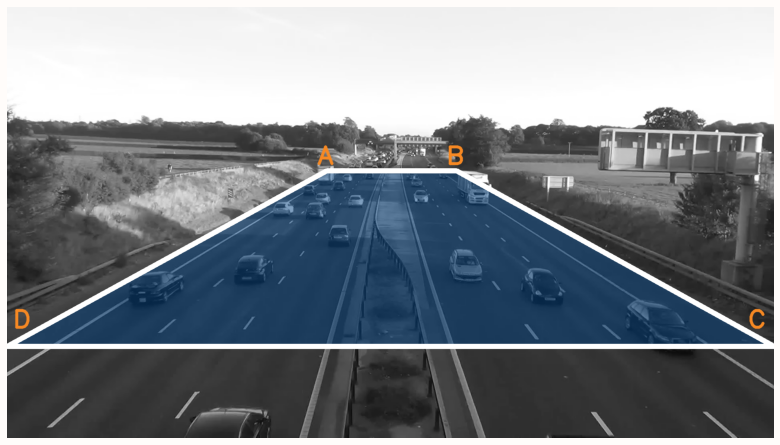

In [5]:
cap = cv.VideoCapture(SOURCE_VIDEO)
ret, img = cap.read()
cap.release()

img = cv.cvtColor(cv.cvtColor(img, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2BGR)

color1 = sv.Color.from_hex("#004080")
color2 = sv.Color.from_hex("#f78923")
poly = np.array(((800, 410), (1125, 410), (1920, 850), (0, 850)))

img = sv.draw_filled_polygon(img, poly, color1, 0.5)
img = sv.draw_polygon(img, poly, sv.Color.WHITE, 12)
img = sv.draw_text(img, "A", sv.Point(800, 370), color2, 2, 6)
img = sv.draw_text(img, "B", sv.Point(1125, 370), color2, 2, 6)
img = sv.draw_text(img, "C", sv.Point(1880, 780), color2, 2, 6)
img = sv.draw_text(img, "D", sv.Point(40, 780), color2, 2, 6)

imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [6]:
class Cam2WorldMapper:
    """Maps points from image to world coordinates using perspective transform."""

    def __init__(self) -> None:
        self.M: NDArray | None = None

    def __call__(self, image_pts: ArrayLike) -> NDArray:
        return self.map(image_pts)

    def find_perspective_transform(self, image_pts: ArrayLike, world_pts: ArrayLike) -> NDArray:
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        world_pts = np.asarray(world_pts, dtype=np.float32).reshape(-1, 1, 2)
        self.M = cv.getPerspectiveTransform(image_pts, world_pts)
        return self.M

    def map(self, image_pts: ArrayLike) -> NDArray:
        if self.M is None:
            raise ValueError("Perspective transform not estimated")
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        return cv.perspectiveTransform(image_pts, self.M).reshape(-1, 2)             

In [7]:
# A, B, C, D previously found in the image.
image_pts = [(800, 410), (1125, 410), (1920, 850), (0, 850)]
# M6 is roughly 32 meters wide and 140 meters long there.
world_pts = [(0, 0), (32, 0), (32, 140), (0, 140)] 

mapper = Cam2WorldMapper()
mapper.find_perspective_transform(image_pts, world_pts)
print(mapper.M)

[[  -0.027557   -0.050103      42.587]
 [-2.9606e-17    -0.52608      215.69]
 [         -0  -0.0031216           1]]


In [8]:
MPS_TO_KPH = 3.6


class Speedometer:
    """Estimates speed of objects in the world coordinates."""

    def __init__(self, mapper: Cam2WorldMapper, fps: int, unit: float = MPS_TO_KPH) -> None:
        self._mapper = mapper
        self._fps = fps
        self._unit = unit
        self._speeds: defaultdict[int, list[int]] = defaultdict(list)

    @property
    def speeds(self) -> defaultdict[int, list[int]]:
        return self._speeds

    def update_with_trace(self, idx: int, image_trace: NDArray) -> None:
        if len(image_trace) > 1:
            world_trace = self._mapper(image_trace)
            # Median displacement in x and y directions.
            # This stabilises after around several frames.
            dx, dy = np.median(np.abs(np.diff(world_trace, axis=0)), axis=0)
            ds = np.linalg.norm((dx, dy))
            self._speeds[idx].append(int(ds * self._fps * self._unit))

    def get_current_speed(self, idx: int) -> int:
        return self._speeds[idx][-1] if self._speeds[idx] else 0

In [9]:
# Custom color palette for object tracking.
colors = ("#007fff", "#0072e6", "#0066cc", "#0059b3", "#004c99", "#004080", "#003366", "#00264d")
color_palette = sv.ColorPalette(list(map(sv.Color.from_hex, colors)))

# The supervision VideoInfo provides some metadata about the video.
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
FPS = video_info.fps

# Polygonal zone that masks out detected objects that are outside it.
poly = np.array([(0, 410), (1920, 410), (1920, 900), (0, 900)])
zone = sv.PolygonZone(poly, (sv.Position.TOP_CENTER, sv.Position.BOTTOM_CENTER))

bbox_annotator = sv.BoxAnnotator(
    color=color_palette,
    thickness=2,
    color_lookup=sv.ColorLookup.TRACK,
)
trace_annotator = sv.TraceAnnotator(
    color=color_palette,
    position=sv.Position.CENTER,
    thickness=2,
    trace_length=FPS,
    color_lookup=sv.ColorLookup.TRACK,
)
label_annotator = sv.RichLabelAnnotator(
    color=color_palette,
    border_radius=2,
    font_size=16,
    color_lookup=sv.ColorLookup.TRACK,
    text_padding=6,
)

In [10]:
yolo = YOLO("yolo11m.pt", task="detect")
speedometer = Speedometer(mapper, FPS)

output_video = "m6-motorway-annotated.mp4"
width, height = video_info.resolution_wh  # Inferenced image size
# YOLO expects the image size to be a multiple of 32
width, height = round(width / 32) * 32, round(height / 32) * 32
classes = [2, 5, 7]  # Car, Bus, Truck
conf = 0.4  # Detetion confidence threshold

with sv.VideoSink(output_video, video_info) as sink:
    for frame in sv.get_video_frames_generator(SOURCE_VIDEO):
        result = yolo.track(
            frame,
            classes=classes,
            conf=conf,
            imgsz=(height, width),
            persist=True,
            verbose=False,
            tracker="bytetrack.yaml",
        )
        detection = sv.Detections.from_ultralytics(result[0])
        # Mask out detections outside the zone.
        detection = detection[zone.trigger(detections=detection)]

        trace_ids = detection.tracker_id  # type: ignore
        speeds: list[int] = list()
        labels: list[str] = list()

        for trace_id in trace_ids:  # type: ignore
            image_trace = trace_annotator.trace.get(trace_id)
            speedometer.update_with_trace(int(trace_id), image_trace)
            current_speed = speedometer.get_current_speed(int(trace_id))
            speeds.append(current_speed)
            labels.append(f"#{trace_id} {current_speed} km/h")

        frame = cv.cvtColor(cv.cvtColor(frame, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2RGB)
        frame = bbox_annotator.annotate(frame, detection)  # type: ignore
        frame = trace_annotator.annotate(frame, detection)  # type: ignore
        frame = label_annotator.annotate(frame, detection, labels=labels)  # type: ignore
        sink.write_frame(frame)

KeyboardInterrupt: 

In [ ]:

compressed = "m6-motorway-annotated-comp.mp4"
subprocess.run(
    [
        "ffmpeg",
        "-i",
        output_video,
        "-crf",
        "18",
        "-preset",
        "veryfast",
        "-vcodec",
        "libx264",
        compressed,
        "-loglevel",
        "quiet",
        "-y",
    ]
)

Video(compressed, width=960, height=540)

In [ ]:
warnings.simplefilter("ignore")
speed_df = pd.DataFrame.from_dict(speedometer.speeds, orient="index").transpose()
speed_df = speed_df.clip(  # Remove extreme outliers and smooth the curve.
    lower=float(np.nanpercentile(speed_df, 1)),
    upper=float(np.nanpercentile(speed_df, 99)),
).apply(lambda x: savgol_filter(x, FPS, 2))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 9), tight_layout=True)
sns.lineplot(speed_df, palette="mako", linewidth=1.25, ax=ax1)
ax1.set_xlabel("Frame")
ax1.set_ylabel("Speed (km/h)")
ax1.get_legend().set_visible(False)
ax1.set_ylim(10, 140)
ax1.set_title(
    "M6 Highway near Knutsford, UK - Speed Distribution",
    loc="left",
    pad=40,
)
sns.kdeplot(speed_df.to_numpy().ravel(), fill=True, color="#004080", linewidth=1, ax=ax2)
ax2.set_xlabel("Speed (km/h)")
ax2.set_ylabel("Density")
plt.show()

In [ ]:
import cv2
from ultralytics import solutions

cap = cv2.VideoCapture("m6-motorway-trim.mp4")
assert cap.isOpened(), "Error reading video file"

# Video writer
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
video_writer = cv2.VideoWriter("speed_management.avi", cv2.VideoWriter_fourcc(*"XVID"), fps, (w, h))


# Speed region points
speed_region = [(20, 400), (1080, 400), (1080, 360), (20, 360)]

# Initialize speed estimation object
speedestimator = solutions.SpeedEstimator(
    show=True,  # display the output
    model="yolo11n.pt",  # path to the YOLO11 model file.
    region=speed_region,  # pass region points
    # classes=[0, 2],  # estimate speed of specific classes.
    # line_width=2,  # adjust the line width for bounding boxes
)


# Process video
frame_count = 0
frame_skip = 2  # Skip every 2nd frame

while cap.isOpened():
    success, im0 = cap.read()

    if not success:
        print("Video frame is empty or processing is complete.")
        break

    frame_count += 1

    if frame_count % frame_skip != 0:
        continue

    # Estimate speed using the 'estimate_speed' method
    results = speedestimator.estimate_speed(im0)  # Use 'estimate_speed' method

    # Write the processed frame directly
    video_writer.write(results)  # Use 'results' directly, as it is a numpy array (image).


cap.release()
video_writer.release()
cv2.destroyAllWindows()  # destroy all opened windows


In [ ]:
import cv2
from ultralytics import solutions

cap = cv2.VideoCapture("m6-motorway-trim.mp4")
assert cap.isOpened(), "Error reading video file"

# region_points = [(20, 400), (1080, 400)]  # line counting
region_points = [(20, 400), (1080, 400), (1080, 360), (20, 360)]  # rectangle region
# region_points = [(20, 400), (1080, 400), (1080, 360), (20, 360), (20, 400)]   # polygon region

# Video writer
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
video_writer = cv2.VideoWriter("object_counting_output.avi", cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

# Initialize object counter object
counter = solutions.ObjectCounter(
    show=True,  # display the output
    region=region_points,  # pass region points
    model="yolo11n.pt",  # model="yolo11n-obb.pt" for object counting with OBB model.
    # classes=[0, 2],  # count specific classes i.e. person and car with COCO pretrained model.
    # tracker="botsort.yaml",  # choose trackers i.e "bytetrack.yaml"
)

# Process video
while cap.isOpened():
    success, im0 = cap.read()

    if not success:
        print("Video frame is empty or processing is complete.")
        break

    # Process the frame using the ObjectCounter object
    results = counter.count(im0)  # Directly pass the frame to the ObjectCounter object

    # Access the results from the object counter
    print(results)  # to check what data is available in results

    # Write the processed frame (results is the processed frame)
    video_writer.write(results)  # Write the processed frame directly.

cap.release()
video_writer.release()
cv2.destroyAllWindows()  # destroy all opened windows


In [9]:
import cv2 as cv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import supervision as sv

# Path to the video source
SOURCE_VIDEO = "m6-motorway-trim.mp4"

# Open the video
cap = cv.VideoCapture(SOURCE_VIDEO)

# Skip the first few frames to warm up the video capture process
for _ in range(5):
    ret, _ = cap.read()

# Now read the first frame after the warm-up
ret, img = cap.read()
cap.release()

# Convert to grayscale and back to BGR for coloring later
img = cv.cvtColor(cv.cvtColor(img, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2BGR)

# Define polygon points and colors
color1 = sv.Color.from_hex("#004080")
color2 = sv.Color.from_hex("#f78923")
poly = np.array(((900, 410), (1125, 410), (1920, 850), (0, 850)))  # Polygon vertices

# Draw filled polygon
img = sv.draw_filled_polygon(img, poly, color1, 0.5)
# Draw polygon border
img = sv.draw_polygon(img, poly, sv.Color.WHITE, 12)

# Add labels to the corners of the polygon
img = sv.draw_text(img, "A", sv.Point(900, 370), color2, 2, 6)
img = sv.draw_text(img, "B", sv.Point(1125, 370), color2, 2, 6)
img = sv.draw_text(img, "C", sv.Point(1880, 780), color2, 2, 6)
img = sv.draw_text(img, "D", sv.Point(40, 780), color2, 2, 6)

# Display the image with drawn polygon and text using OpenCV (same as matplotlib window size)
cv.namedWindow("Processed Frame", cv.WINDOW_NORMAL)
cv.resizeWindow("Processed Frame", 1280, 720)  # Resize to 1280x720
cv.imshow("Processed Frame", img)

# Wait until a key is pressed and then close the window
cv.waitKey(0)
cv.destroyAllWindows()


ModuleNotFoundError: No module named 'pandas._libs'

In [3]:
print(dir(list))

['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']
